<a href="https://colab.research.google.com/github/seddigheh-binazadeh/automatic-speech-recognition/blob/main/speech_recognition_LJspeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# access to google drive

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# GPU

In [ ]:
!nvidia-smi

Wed Feb 14 07:02:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#Install

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 7.5 MB/s eta 0:00:00


In [ ]:
#!pip install soundfile
!pip install sox

In [ ]:
!pip install librosa

#Imports

In [ ]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset,random_split
from torch.nn.utils.rnn import pad_sequence

import torchvision
from torchvision.models import resnet18, ResNet18_Weights

import torchaudio
from torchaudio import datasets
from torchaudio import transforms as T
from torchaudio import models
from torchaudio import pipelines

from torch.nn.utils.rnn import pad_sequence

import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from sklearn.model_selection import train_test_split

import librosa
from tqdm import tqdm
from IPython.display import Audio

import pandas as pd
from collections import defaultdict

import random
import math
import matplotlib.pyplot as plt

In [ ]:
str(torchaudio._backend.get_audio_backend())

<ipython-input-7-d9408986f228>:1: UserWarning: torchaudio._backend.get_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  str(torchaudio._backend.get_audio_backend())


'None'

In [ ]:
print(torch.__version__)
print(torchaudio.__version__)

2.1.0+cu121
2.1.0+cu121


# Device

In [ ]:
device ='cuda' if torch.cuda.is_available() else 'cpu'

#Utils

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [ ]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

In [ ]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

In [ ]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)

In [ ]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(T.AmplitudeToDB()(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [ ]:
def num_trainables_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

#Dataset

## Transform & Augmentation

In [ ]:
!cp -r /content/drive/MyDrive/deep-learning-2022-howsam/audio/audio_sampels /content/audio_samples

torch.Size([1, 128, 213]) torch.Size([1, 54400])


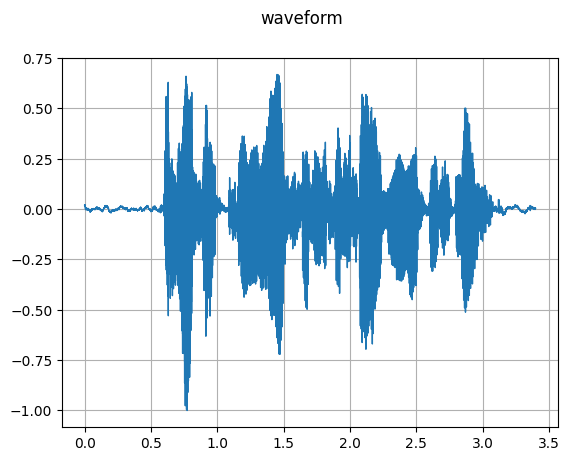

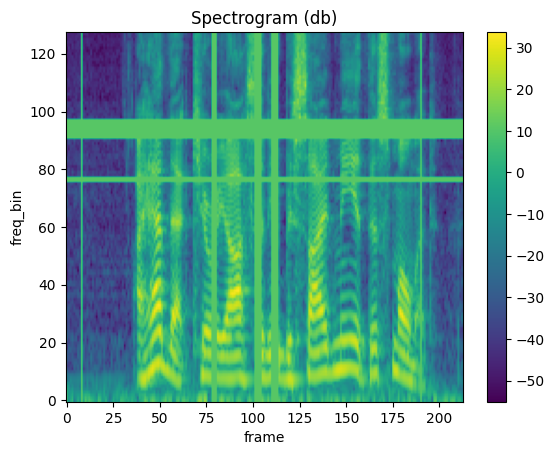

In [ ]:
waveform, sample_rate = torchaudio.load('/content/audio_samples/speech.wav')
transform_train =nn.Sequential (T.MelSpectrogram(sample_rate = sample_rate,n_fft = 1024,n_mels =128,hop_length=256,win_length=512),
                                T.SpecAugment(n_time_masks =5 , time_mask_param= 5, n_freq_masks =2, freq_mask_param=10),
                                )
spec = transform_train(waveform)
print(transform_train(waveform).shape,waveform.shape)
plot_waveform(waveform,sample_rate)
plot_spectrogram(spec[0])

In [ ]:
transform_test = T.MelSpectrogram(sample_rate = sample_rate,n_fft = 1024,n_mels =128,hop_length=256,win_length=512)
transform_test(waveform).shape, waveform.shape

(torch.Size([1, 128, 213]), torch.Size([1, 54400]))

## load Dataset

In [ ]:
data = datasets.LJSPEECH('/content/',download = True )

100%|██████████| 2.56G/2.56G [00:39<00:00, 68.9MB/s]


## split files

In [ ]:
!cp -r /content/drive/MyDrive/Deep-catalyst/project-4-speech-recognition/ljspeech-splited-data/train.txt /content/train.txt
!cp -r /content/drive/MyDrive/Deep-catalyst/project-4-speech-recognition/ljspeech-splited-data/test.txt /content/test.txt
!cp -r /content/drive/MyDrive/Deep-catalyst/project-4-speech-recognition/ljspeech-splited-data/valid.txt /content/valid.txt

In [ ]:
!mkdir '/content/splited-set'

In [ ]:
def splited_list(sub_set:str):
  phase = sub_set
  file = f'/content/{phase}.txt'
  with open (file) as f:
    splited_sample = f.read().strip().split('\n')

  splited_list = [name for name in splited_sample]
  torch.save(splited_list, f'/content/splited-set/{phase}.pt')
  return splited_list

In [ ]:
train_list = splited_list('train')
valid_list = splited_list('valid')
test_list = splited_list('test')

In [ ]:
len(train_list), len(valid_list), len(test_list)

(12500, 100, 500)

In [ ]:
class LJSpeechDataset(Dataset):

  def __init__(self, metadata_dir, sub_set:str, transform= None):
    self.root = metadata_dir
    phase = sub_set
    self.splited_file = torch.load(f'/content/splited-set/{phase}.pt') #list

    self.samples = []

    with open (self.root) as f:
      lines = f.read().strip().split("\n")
    for line in lines:
      if (line.split("|")[0]) in self.splited_file:
        self.samples.append(line.split("|"))

    self.transform = transform

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    sample = self.samples[idx]
    file_id , transcript, normalized_transcript = sample
    #file_id += file_id +'.wav'
    file_name = os.path.join('/content/LJSpeech-1.1/wavs',file_id + '.wav')
    #print(file_name)
    waveform , sample_rate = torchaudio.load(file_name)
    #Audio(waveform, sample_rate)
    if self.transform is not None:
     waveform = self.transform(waveform)
    return file_id , waveform, sample_rate,transcript, normalized_transcript

In [ ]:
valid_data = LJSpeechDataset('/content/LJSpeech-1.1/metadata.csv', 'valid', transform = transform_train)
train_data = LJSpeechDataset('/content/LJSpeech-1.1/metadata.csv', 'train', transform = transform_test)
test_data = LJSpeechDataset('/content/LJSpeech-1.1/metadata.csv', 'test', transform = transform_test)

In [ ]:
len(train_data), len(valid_data), len(test_data)

(12500, 100, 500)

In [ ]:
train_data[66]

('LJ001-0070',
 tensor([[[1.8481e-04, 1.1203e-03, 2.9342e-04,  ..., 1.7742e-05,
           3.0986e-05, 3.1287e-05],
          [1.8504e-04, 2.7512e-03, 3.0563e-04,  ..., 6.6720e-05,
           6.7305e-05, 4.8788e-05],
          [1.7665e-04, 5.4889e-03, 4.6533e-03,  ..., 1.4779e-04,
           9.6888e-05, 6.7417e-05],
          ...,
          [2.1664e-06, 1.9122e-05, 7.6143e-05,  ..., 3.0155e-06,
           1.0818e-05, 4.3371e-06],
          [8.1833e-07, 4.2466e-06, 8.6787e-05,  ..., 2.1438e-06,
           3.1054e-06, 2.4112e-06],
          [6.8240e-07, 2.2313e-06, 8.4418e-05,  ..., 1.6722e-07,
           2.9891e-07, 7.6096e-07]]]),
 22050,
 'and was used there with very little variation all through the sixteenth and seventeenth centuries, and indeed into the eighteenth.',
 'and was used there with very little variation all through the sixteenth and seventeenth centuries, and indeed into the eighteenth.')

wave shape: torch.Size([1, 128, 302])
Sample Rate: 22050
spectrogram(waveform).shape :torch.Size([1, 128, 302])


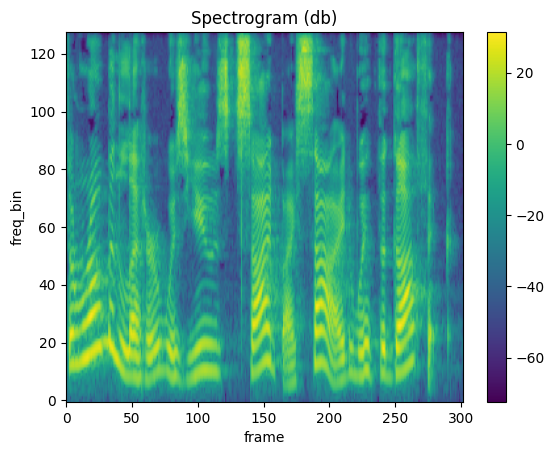

the Roman letter was used side by side with the Gothic.


In [ ]:
index = random.randint(0,100)
temp = train_data[index] #testing train_data, valid_data, test_data
file_name = os.path.join('/content/LJSpeech-1.1/wavs',temp[0] +'.wav')
print(f'wave shape: {temp[1].shape}')
print(f'Sample Rate: {temp[2]}')
#plot_specgram(temp[1], temp[2], title="Spectrogram")
#spec = spectrogram(temp[1])
print(f'spectrogram(waveform).shape :{temp[1].shape}')
#plot_spectrogram(temp[1][0])
#spec = mels(temp[1])
plot_spectrogram(temp[1][0])
print(temp[-1])
Audio(file_name)

##EDA

#DataLoader

##build dictionary

In [ ]:
def unique_char(data):
  #
  a = [line[-1] for line in data]
  c = ''
  for b in a:
    c += b
  d = list(sorted(set(c.lower())))
  print (f'Number of Unique Character in train normalized transcript is:{len(d)}')
  #dictionary = {'pad':0, 'sos':1, 'eos':2 }
  special_Tag = ['pad', 'sos', 'eos','unk']
  start = len(special_Tag)
  dictionary = {key:value+start for value, key in enumerate(d)}

  for value , key in enumerate(special_Tag):
    dictionary[key] = value

  return dictionary

In [ ]:
dic = unique_char(train_data)
len(dic), dic['pad'],dic['p'],dic

Number of Unique Character in train normalized transcript is:49


(53,
 0,
 33,
 {' ': 4,
  '!': 5,
  '"': 6,
  "'": 7,
  '(': 8,
  ')': 9,
  ',': 10,
  '-': 11,
  '.': 12,
  ':': 13,
  ';': 14,
  '?': 15,
  '[': 16,
  ']': 17,
  'a': 18,
  'b': 19,
  'c': 20,
  'd': 21,
  'e': 22,
  'f': 23,
  'g': 24,
  'h': 25,
  'i': 26,
  'j': 27,
  'k': 28,
  'l': 29,
  'm': 30,
  'n': 31,
  'o': 32,
  'p': 33,
  'q': 34,
  'r': 35,
  's': 36,
  't': 37,
  'u': 38,
  'v': 39,
  'w': 40,
  'x': 41,
  'y': 42,
  'z': 43,
  'à': 44,
  'â': 45,
  'è': 46,
  'é': 47,
  'ê': 48,
  'ü': 49,
  '’': 50,
  '“': 51,
  '”': 52,
  'pad': 0,
  'sos': 1,
  'eos': 2,
  'unk': 3})

In [ ]:
def str2id(line):
  line_char = list(line.lower())
  id =[]
  for k in line_char:
    if k in dic:
      id.append(dic[k])
    else:
      id.append(dic['unk'])
  return id

In [ ]:
len(dic)

53

##DataLoader

In [ ]:
def collate_fn(batch):
  #The spectrogram is in (1,128, 407) and (1,128, 355) for example but later on
  #for padding the function expects (407, 128) and (355, 128).
  #So we need to elemenate first dim and then transpose the matrices.
  data = [b[1][0].squeeze(0).transpose(0,1) for b in batch]
  data = torch.Tensor(pad_sequence(data, batch_first=True, padding_value = dic['pad'])).unsqueeze(1).transpose(2,3)   #(batch, channel=1, features, time )
  sentences = [b[-1] for b in batch]
  labels =[torch.tensor(str2id(b[-1])) for b in batch]
  label_id = pad_sequence(labels, batch_first=True, padding_value = dic['pad'])
  return data,label_id

In [ ]:
train_loader = DataLoader(train_data,batch_size =16, shuffle = True, collate_fn = collate_fn)
valid_loader = DataLoader(valid_data,batch_size =16, shuffle = False,collate_fn = collate_fn)
test_loader = DataLoader(test_data,batch_size = 16, shuffle = False,collate_fn = collate_fn)

In [ ]:
data,label_id = next(iter(valid_loader))
label_id.shape,data.shape

(torch.Size([16, 171]), torch.Size([16, 1, 128, 865]))

### Define DataLoader

In [ ]:
data_train, label_train = next(iter(train_loader))
data_train.shape, label_train.shape

(torch.Size([16, 1, 128, 864]), torch.Size([16, 174]))

In [ ]:
data_val, label_val = next(iter(valid_loader))
data_val.shape, label_val.shape

(torch.Size([16, 1, 128, 865]), torch.Size([16, 171]))

In [ ]:
data_test, label_test = next(iter(test_loader))
data_test.shape, label_test.shape

(torch.Size([16, 1, 128, 833]), torch.Size([16, 166]))

#Model

In [ ]:
class ConvlutionLayer(nn.Module):
  'extract features from melspectrogram of original audio'
  def __init__(self,):
    super().__init__()

    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.requires_grad_(True)
    self.model = nn.Sequential(*list(model.children())[:-4])
    self.maxpool= nn.MaxPool2d(2, stride=2)

  def forward(self,x):

    y = self.model(x)
    outputs = self.maxpool(y)
    #print(outputs.shape)

    batch_size, channels, dimension, seq_lengths = outputs.size()
    outputs = outputs.permute(0,3,1,2)
    outputs = outputs.view(batch_size, seq_lengths,dimension*channels)
    if dimension * channels  != 1024:
      print(dimension*channels)
      #y = np.zeros(batch_size,seq_lengths, 1024)
      #y = outputs[:batch_size, :seq_lengths,:dimension*channels]



    return outputs

In [ ]:
model= ConvlutionLayer()
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 62.7MB/s]


ConvlutionLayer(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [ ]:
num_trainables_params(model)

0.6768

In [ ]:
model.training

True

In [ ]:
y_temp = model(data_test)
y_temp.shape


torch.Size([16, 52, 1024])

##Transformer part

In [ ]:
def create_mask(src, tgt):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    src_mask = torch.nn.Transformer.generate_square_subsequent_mask(src_seq_len).to(src.device)
    tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(tgt_seq_len).to(tgt.device)


    padding_value = dic['pad']
    src_key_padding_mask = (src[:, :, 0] == padding_value)  # Assuming the feature dimension is 0
    tgt_key_padding_mask = (tgt[:, :, 0] == padding_value)
    return src_mask, tgt_mask, src_key_padding_mask, tgt_key_padding_mask

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        pe = self.pe[:, :seq_len]
        pe = pe.repeat(batch_size, 1, 1)
        return x + pe

In [ ]:
#testing positionalencoding
d_model = 512
max_len = 500
pe = PositionalEncoding(d_model)
x = torch.randn(16, 15, d_model)
output = pe(x)
print(output.size())

torch.Size([16, 15, 512])


In [ ]:
class LJSpeechModel(nn.Module):
  def __init__(self,
               dic_size,
               d_model = 1024,
               nheads = 4,
               num_encoder_layers=6,
               num_decoder_layers = 6,
               dim_feedforward = 4 * d_model,
               dropout=0.1,
               ):
    super().__init__()
    self.embedding = nn.Embedding(dic_size,d_model,padding_idx = dic['pad'])
    self.transformer = nn.Transformer(d_model=d_model,
                                      nhead = nheads ,
                                      num_encoder_layers=num_encoder_layers,
                                      num_decoder_layers=num_decoder_layers,
                                      dim_feedforward= dim_feedforward,
                                      dropout=dropout,
                                      batch_first=True)
    self.fc = nn.Linear(d_model, dic_size)
    self.PositionalEncoding_src = PositionalEncoding(d_model)
    self.PositionalEncoding_tgt = PositionalEncoding(d_model)
    self.dic_size = dic_size
    self.feater_extractor = ConvlutionLayer()

  def forward(self,
              src: Tensor,
              trg: Tensor,
              #src_mask: Tensor,
              #trg_mask: Tensor,
              #src_padding_mask: Tensor,
              #trg_padding_mask: Tensor,
              ):
    src = self.feater_extractor(src)
    #print(src.shape, self.PositionalEncoding_src(src).shape)
    src =   self.PositionalEncoding_src(src)
    trg_emb = self.embedding(trg.long())
    trg = self.PositionalEncoding_tgt(trg_emb)
    src_mask, trg_mask, src_padding_mask, trg_padding_mask = create_mask(src,trg)
    outs = self.transformer(src, trg, src_mask, trg_mask)#,None,
                                #src_padding_mask, trg_padding_mask)
    outs = self.fc(outs)
    return outs

In [ ]:
src , tgt = next(iter(valid_loader))
print(src.shape, tgt.shape)
model = LJSpeechModel(dic_size = len(dic),d_model = 1024)
y_out = model(src,tgt)
y_out.shape

torch.Size([16, 1, 128, 865]) torch.Size([16, 171])


torch.Size([16, 171, 53])

In [ ]:
num_trainables_params(model)

126.790645

#

# Config

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
clip =0.1

In [ ]:
model = LJSpeechModel(dic_size = len(dic),d_model = 1024).to(device)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr = 3, weight_decay = 0, momentum = 0.9)
loss_fn = nn.CrossEntropyLoss(ignore_index=dic['pad'])

# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs,targets[:,:-1])

      loss = loss_fn(outputs.reshape(-1,outputs.shape[-1]), targets[:,1:].flatten())

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm = clip)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())

      tepoch.set_postfix(loss=loss_train.avg,
                         )
  return  model , loss_train.avg

# 🔴 **Evaluation**

In [ ]:
def evaluate(model, test_loader, loss_fn):
  model.eval()
  loss_eval = AverageMeter()
  #metric.reset()

  with torch.inference_mode():
    for src,tgt in test_loader:
      src = src.to(device)
      tgt = tgt.to(device)

      outputs = model(src,tgt[:,:-1])

      loss = loss_fn(outputs.reshape(-1,outputs.shape[-1]), tgt[:,1:].flatten())
      loss_eval.update(loss.item(), n=len(tgt))

      #metric(outputs, targets)

  return loss_eval.avg#, metric.compute().item()

# 🔴 **Training Process 〽️**

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few

In [ ]:
model = model.to(device)

src, tgt = next(iter(train_loader))
src = src.to(device)
tgt = tgt.to(device)
target = tgt[:,1:].to(device)

with torch.no_grad():
  outputs = model(src, tgt[:,:-1])
  loss = loss_fn(outputs.reshape(-1,outputs.shape[-1]), target.flatten())

print(loss)

tensor(4.1357, device='cuda:0')


In [ ]:
outputs.reshape(-1,outputs.shape[-1]).shape, target.flatten().shape

(torch.Size([2160, 53]), torch.Size([2160]))

**bold text**### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
mini_train_data,_ = random_split(train_data ,[1000, len(train_data)-1000] )
mini_train_loader = train_loader = DataLoader(mini_train_data,batch_size =16, shuffle = True, collate_fn = collate_fn)

In [ ]:
model = LJSpeechModel(dic_size = len(dic),d_model = 1024).to(device)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr = 0.9, weight_decay = 0, momentum = 0.9)
loss_fn = nn.CrossEntropyLoss(ignore_index=dic['pad'])

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
   model,_ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 9: 100%|██████████| 63/63 [00:47<00:00,  1.32batch/s, loss=2.19]


In [ ]:
lr = 0.5
num_epochs = 10
for epoch in range(num_epochs):
   model,_ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 9: 100%|██████████| 63/63 [00:47<00:00,  1.33batch/s, loss=1.67]


### Step 3: select best lr

In [ ]:
num_epochs = 3
for lr in [3, 2, 1, 0.5 , 0.1]:
  print(f'LR={lr}')
  model = LJSpeechModel(dic_size = len(dic),d_model = 1024).to(device)
  #model = torch.load('model.pt')
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
  for epoch in range(num_epochs):
    model, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

LR=3


Epoch 2: 100%|██████████| 63/63 [00:47<00:00,  1.32batch/s, loss=3.35]



LR=2


Epoch 2: 100%|██████████| 63/63 [00:48<00:00,  1.30batch/s, loss=2.63]



LR=1


Epoch 2: 100%|██████████| 63/63 [00:47<00:00,  1.33batch/s, loss=2.56]



LR=0.5


Epoch 2: 100%|██████████| 63/63 [00:47<00:00,  1.33batch/s, loss=2.47]



LR=0.1


Epoch 2: 100%|██████████| 63/63 [00:47<00:00,  1.32batch/s, loss=2.52]

### Step 4: small grid (optional)

Create a small grid based on the WD and the best LR

In [ ]:
num_epochs = 2

for lr in [0.25, 0.4, 0.5, 0.6, 0.75]:
  for wd in [1e-4, 1e-5, 0.]:
    model = LJSpeechModel(dic_size = len(dic),d_model = 1024).to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()

LR=0.25, WD=0.0001


Epoch 1: 100%|██████████| 63/63 [00:43<00:00,  1.46batch/s, loss=2.94]



LR=0.25, WD=1e-05


Epoch 1: 100%|██████████| 63/63 [00:43<00:00,  1.44batch/s, loss=2.93]



LR=0.25, WD=0.0


Epoch 1: 100%|██████████| 63/63 [00:43<00:00,  1.45batch/s, loss=2.93]



LR=0.4, WD=0.0001


Epoch 1: 100%|██████████| 63/63 [00:43<00:00,  1.44batch/s, loss=2.96]



LR=0.4, WD=1e-05


Epoch 1: 100%|██████████| 63/63 [00:43<00:00,  1.46batch/s, loss=2.95]



LR=0.4, WD=0.0


Epoch 1: 100%|██████████| 63/63 [00:53<00:00,  1.18batch/s, loss=2.95]



LR=0.5, WD=0.0001


Epoch 1: 100%|██████████| 63/63 [00:43<00:00,  1.46batch/s, loss=2.96]



LR=0.5, WD=1e-05


Epoch 1: 100%|██████████| 63/63 [00:43<00:00,  1.44batch/s, loss=2.96]



LR=0.5, WD=0.0


Epoch 1: 100%|██████████| 63/63 [00:43<00:00,  1.46batch/s, loss=2.96]



LR=0.6, WD=0.0001


Epoch 1: 100%|██████████| 63/63 [00:43<00:00,  1.45batch/s, loss=2.97]



LR=0.6, WD=1e-05


Epoch 1: 100%|██████████| 63/63 [00:42<00:00,  1.48batch/s, loss=2.96]



LR=0.6, WD=0.0


Epoch 1: 100%|██████████| 63/63 [00:42<00:00,  1.49batch/s, loss=2.96]



LR=0.75, WD=0.0001


Epoch 1: 100%|██████████| 63/63 [00:43<00:00,  1.45batch/s, loss=2.97]



LR=0.75, WD=1e-05


Epoch 1: 100%|██████████| 63/63 [00:43<00:00,  1.45batch/s, loss=2.98]



LR=0.75, WD=0.0


Epoch 1: 100%|██████████| 63/63 [00:42<00:00,  1.48batch/s, loss=2.98]

### Step 5: train more epochs

In [ ]:
model = LJSpeechModel(dic_size = len(dic),d_model = 1024).to(device)

In [ ]:
lr = 0.05
wd = 0
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid = evaluate(model,
                        test_loader,
                        loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)



  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 63/63 [00:42<00:00,  1.48batch/s, loss=1.67]


Model Saved!
Valid: Loss = 1.813



Epoch 1: 100%|██████████| 63/63 [00:42<00:00,  1.50batch/s, loss=1.64]


Model Saved!
Valid: Loss = 1.807



Epoch 2: 100%|██████████| 63/63 [00:42<00:00,  1.47batch/s, loss=1.63]


Valid: Loss = 1.808



Epoch 3: 100%|██████████| 63/63 [00:42<00:00,  1.48batch/s, loss=1.62]


Model Saved!
Valid: Loss = 1.805



Epoch 4: 100%|██████████| 63/63 [00:42<00:00,  1.48batch/s, loss=1.62]


Valid: Loss = 1.805



Epoch 5: 100%|██████████| 63/63 [00:42<00:00,  1.48batch/s, loss=1.61]


Model Saved!
Valid: Loss = 1.799



Epoch 6: 100%|██████████| 63/63 [00:43<00:00,  1.46batch/s, loss=1.6]


Valid: Loss = 1.801



Epoch 7: 100%|██████████| 63/63 [00:42<00:00,  1.48batch/s, loss=1.6]


Valid: Loss = 1.799



Epoch 8: 100%|██████████| 63/63 [00:42<00:00,  1.47batch/s, loss=1.59]


Model Saved!
Valid: Loss = 1.797



Epoch 9: 100%|██████████| 63/63 [00:42<00:00,  1.49batch/s, loss=1.58]


Model Saved!
Valid: Loss = 1.795



In [ ]:
torch.save(model, '/content/drive/MyDrive/Deep-catalyst/project-4-speech-recognition/saved-model/model.pt')

# Plot

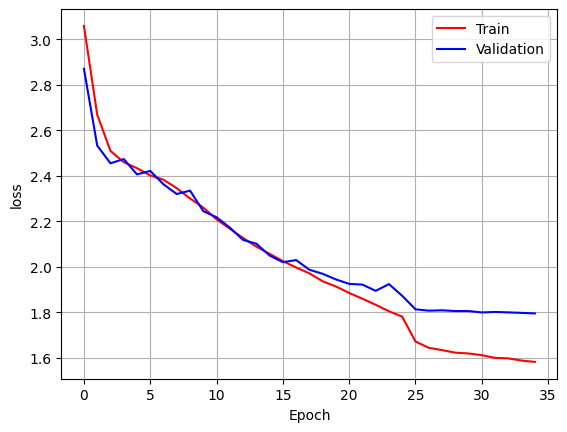

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()